In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
a = pd.read_csv('../../Data/accepted.csv')
a.shape

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2260701, 151)

In [4]:
drop = a[a.funded_amnt.isnull()].index
a.drop(drop, axis=0, inplace=True)
a.shape

(2260668, 151)

In [5]:
a = a[['fico_range_low', 'fico_range_high', 'loan_status']]
a = a.assign(FICO = (a['fico_range_low'] + a['fico_range_high'])/2)
a = a[['FICO', 'loan_status']]
a

,FICO,loan_status
0,677.0,Fully Paid
1,717.0,Fully Paid
2,697.0,Fully Paid
3,787.0,Current
4,697.0,Fully Paid
...,...,...
2260694,667.0,Current
2260695,697.0,Current
2260696,707.0,Current
2260697,662.0,Charged Off


In [6]:
a.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [7]:
a['loan_status'].replace({'Current':np.nan, 
                          'Late (31-120 days)':np.nan,
                          'In Grace Period':np.nan,
                          'Late (16-30 days)':np.nan,
                          'Does not meet the credit policy. Status:Fully Paid':'Fully Paid',
                          'Does not meet the credit policy. Status:Charged Off':'Charged Off',
                          'Default':'Charged Off'}, inplace=True)

In [8]:
878317 + 21467 + 8436 + 4349

912569

In [9]:
1076751 + 1988

1078739

In [10]:
268559 + 761 + 40

269360

In [11]:
a['loan_status'].value_counts(dropna=False)

Fully Paid     1078739
NaN             912569
Charged Off     269360
Name: loan_status, dtype: int64

In [12]:
a = a.dropna().reset_index(drop=True)
a

,FICO,loan_status
0,677.0,Fully Paid
1,717.0,Fully Paid
2,697.0,Fully Paid
3,697.0,Fully Paid
4,692.0,Fully Paid
...,...,...
1348094,737.0,Fully Paid
1348095,707.0,Fully Paid
1348096,737.0,Charged Off
1348097,667.0,Fully Paid


In [13]:
a = a.assign(ls_numeric = a['loan_status'].replace({'Fully Paid':1, 
                          'Charged Off':0}))

In [14]:
a

,FICO,loan_status,ls_numeric
0,677.0,Fully Paid,1
1,717.0,Fully Paid,1
2,697.0,Fully Paid,1
3,697.0,Fully Paid,1
4,692.0,Fully Paid,1
...,...,...,...
1348094,737.0,Fully Paid,1
1348095,707.0,Fully Paid,1
1348096,737.0,Charged Off,0
1348097,667.0,Fully Paid,1


In [15]:
a.groupby('loan_status').describe()

FICO                                                     \
                 count        mean        std    min    25%    50%    75%   
loan_status                                                                 
Charged Off   269360.0  689.831386  25.956008  617.0  672.0  682.0  702.0   
Fully Paid   1078739.0  700.242523  32.831822  612.0  677.0  692.0  717.0   

                   ls_numeric                                     
               max      count mean  std  min  25%  50%  75%  max  
loan_status                                                       
Charged Off  847.5   269360.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Fully Paid   847.5  1078739.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

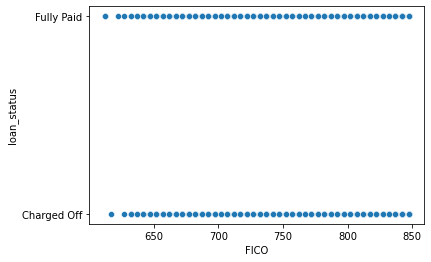

In [16]:
#It doesn't seem like FICO is a good predictor from EDA? 

sns.scatterplot(data=a, x='FICO', y='loan_status');

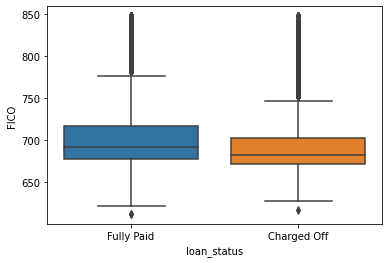

In [17]:
#It doesn't seem like FICO is a good predictor from EDA? 

sns.boxplot(data=a, x='loan_status', y='FICO');

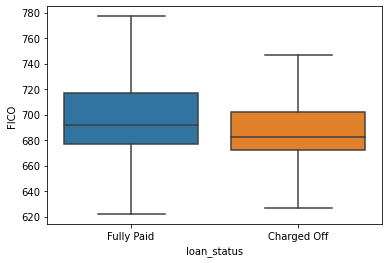

In [18]:
#It doesn't seem like FICO is a good predictor from EDA? 

sns.boxplot(data=a, x='loan_status', y='FICO', showfliers=False);

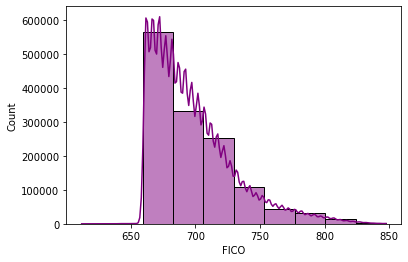

In [19]:
#For Two-Sample Student's T-test
#Assumption 1: Independence of Observations, Should be OK. Result of one loan, shouldn't affect result of another. 
#Assumption 2: Distribution of Numerical Variable should be close to "normal". We can test for this:

ax = sns.histplot(a.FICO, bins=10, kde=True, color='purple')

#Not normally distributed!!! Ouch. 


In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [21]:
x = np.array(a.FICO).reshape(-1,1)
y = a.ls_numeric

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [23]:
clf.fit(x_train, y_train)

LogisticRegression()

In [24]:
clf.score(x_test, y_test)

0.8001928640308582

In [25]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(x_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
confusion_matrix(y_test, y_pred)

array([[     0,  80808],
       [     0, 323622]])

In [27]:
clf.score(np.array(y_pred).reshape(-1,1), y_test)

0.8001928640308582

In [28]:
x_test

array([[702.],
       [667.],
       [682.],
       ...,
       [747.],
       [667.],
       [752.]])

In [29]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [30]:
y_test

364067     1
1193863    0
479957     0
266704     1
1046697    1
          ..
444234     1
956361     1
1211872    1
369585     1
551226     1
Name: ls_numeric, Length: 404430, dtype: int64

In [31]:
clf2 = LogisticRegression(class_weight = 'balanced')

In [32]:
clf2.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

In [33]:
clf2.score(x_test, y_test)

0.5125732512424894

In [34]:
y_pred2 = clf2.predict(x_test)
y_pred2

array([1, 0, 0, ..., 1, 0, 1])

In [35]:
y_test

364067     1
1193863    0
479957     0
266704     1
1046697    1
          ..
444234     1
956361     1
1211872    1
369585     1
551226     1
Name: ls_numeric, Length: 404430, dtype: int64

In [36]:
cm = confusion_matrix(y_test, y_pred2)
cm

array([[ 53361,  27447],
       [169683, 153939]])

In [37]:
cm.ravel()

array([ 53361,  27447, 169683, 153939])

In [38]:
y

0          1
1          1
2          1
3          1
4          1
          ..
1348094    1
1348095    1
1348096    0
1348097    1
1348098    0
Name: ls_numeric, Length: 1348099, dtype: int64

In [39]:
a

,FICO,loan_status,ls_numeric
0,677.0,Fully Paid,1
1,717.0,Fully Paid,1
2,697.0,Fully Paid,1
3,697.0,Fully Paid,1
4,692.0,Fully Paid,1
...,...,...,...
1348094,737.0,Fully Paid,1
1348095,707.0,Fully Paid,1
1348096,737.0,Charged Off,0
1348097,667.0,Fully Paid,1


In [40]:
print('Labels: {}'.format(set(y)))
print('Zero count or Charged Off = {}, One count or Fully Paid = {}'.format(len(y) - sum(y), sum(y)))
print('Ratio of One count or Fully Paid = {}'.format(sum(y)/len(y)))
print('Total Observations = {}'.format(len(y)))
print('Total Testing Sample = {}'.format(len(y)*0.3))

a1, b1, c1, d1 = confusion_matrix(y_test, y_pred2).ravel()
print('Confusion Matrix Total = {}'.format(a1+b1+c1+d1))
print('Confusion Matrix Actual Paid Off = {}'.format((a1+b1+c1+d1)*(sum(y)/len(y))))
print('Confusion Matrix Actual Charged Off = {}'.format((a1+b1+c1+d1)-((a1+b1+c1+d1)*(sum(y)/len(y)))))

Labels: {0, 1}
Zero count or Charged Off = 269360, One count or Fully Paid = 1078739
Ratio of One count or Fully Paid = 0.8001927158168651
Total Observations = 1348099
Total Testing Sample = 404429.7
Confusion Matrix Total = 404430
Confusion Matrix Actual Paid Off = 323621.94005781476
Confusion Matrix Actual Charged Off = 80808.05994218524


In [41]:
cmdf = pd.DataFrame(cm, index=["Actual_Default","Actual_Fully_Paid"],
                        columns=["Predicted_Default","Predicted_Fully_Paid"])

cmdf

,Predicted_Default,Predicted_Fully_Paid
Actual_Default,53361,27447
Actual_Fully_Paid,169683,153939


In [42]:
clf2.score(x,y)

0.513394045986237

In [43]:
y_pred_full1 = clf.predict(x)
print(len(y_pred_full1))
y_pred_full1

1348099


array([1, 1, 1, ..., 1, 1, 1])

In [44]:
Predictions1 = pd.Series(y_pred_full1)
Predictions1

0          1
1          1
2          1
3          1
4          1
          ..
1348094    1
1348095    1
1348096    1
1348097    1
1348098    1
Length: 1348099, dtype: int64

In [45]:
a

,FICO,loan_status,ls_numeric
0,677.0,Fully Paid,1
1,717.0,Fully Paid,1
2,697.0,Fully Paid,1
3,697.0,Fully Paid,1
4,692.0,Fully Paid,1
...,...,...,...
1348094,737.0,Fully Paid,1
1348095,707.0,Fully Paid,1
1348096,737.0,Charged Off,0
1348097,667.0,Fully Paid,1


In [46]:
type(a)

pandas.core.frame.DataFrame

In [47]:
a_predict = a.assign(Predictions1 = Predictions1)
a_predict

,FICO,loan_status,ls_numeric,Predictions1
0,677.0,Fully Paid,1,1
1,717.0,Fully Paid,1,1
2,697.0,Fully Paid,1,1
3,697.0,Fully Paid,1,1
4,692.0,Fully Paid,1,1
...,...,...,...,...
1348094,737.0,Fully Paid,1,1
1348095,707.0,Fully Paid,1,1
1348096,737.0,Charged Off,0,1
1348097,667.0,Fully Paid,1,1


In [48]:
a_predict.describe()

,FICO,ls_numeric,Predictions1
count,1.348099e+06,1.348099e+06,1348099.0
mean,6.981623e+02,8.001927e-01,1.0
std,3.185111e+01,3.998555e-01,0.0
min,6.120000e+02,0.000000e+00,1.0
25%,6.720000e+02,1.000000e+00,1.0
50%,6.920000e+02,1.000000e+00,1.0
75%,7.120000e+02,1.000000e+00,1.0
max,8.475000e+02,1.000000e+00,1.0


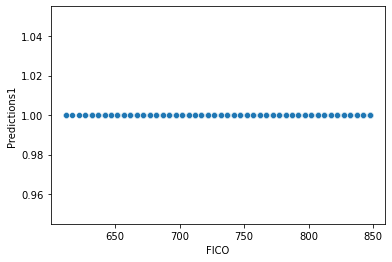

In [49]:
#It doesn't seem like FICO is a good predictor from EDA? 

sns.scatterplot(data=a_predict, x='FICO', y='Predictions1');

In [50]:
y_pred_full2 = clf2.predict(x)
print(len(y_pred_full2))
y_pred_full2

1348099


array([0, 1, 1, ..., 1, 0, 0])

In [51]:
Predictions2 = pd.Series(y_pred_full2)
Predictions2

0          0
1          1
2          1
3          1
4          0
          ..
1348094    1
1348095    1
1348096    1
1348097    0
1348098    0
Length: 1348099, dtype: int64

In [52]:
a_predict = a_predict.assign(Predictions2 = Predictions2)
a_predict

,FICO,loan_status,ls_numeric,Predictions1,Predictions2
0,677.0,Fully Paid,1,1,0
1,717.0,Fully Paid,1,1,1
2,697.0,Fully Paid,1,1,1
3,697.0,Fully Paid,1,1,1
4,692.0,Fully Paid,1,1,0
...,...,...,...,...,...
1348094,737.0,Fully Paid,1,1,1
1348095,707.0,Fully Paid,1,1,1
1348096,737.0,Charged Off,0,1,1
1348097,667.0,Fully Paid,1,1,0


In [53]:
a_predict.describe()

,FICO,ls_numeric,Predictions1,Predictions2
count,1.348099e+06,1.348099e+06,1348099.0,1.348099e+06
mean,6.981623e+02,8.001927e-01,1.0,4.485027e-01
std,3.185111e+01,3.998555e-01,0.0,4.973411e-01
min,6.120000e+02,0.000000e+00,1.0,0.000000e+00
25%,6.720000e+02,1.000000e+00,1.0,0.000000e+00
50%,6.920000e+02,1.000000e+00,1.0,0.000000e+00
75%,7.120000e+02,1.000000e+00,1.0,1.000000e+00
max,8.475000e+02,1.000000e+00,1.0,1.000000e+00


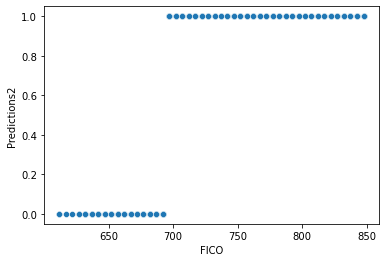

In [54]:
#It doesn't seem like FICO is a good predictor from EDA? 

sns.scatterplot(data=a_predict, x='FICO', y='Predictions2');

In [55]:
#Cutoff point is 692 ~ 697 when "equally balanced" to minimize log-loss. 
a_predict.groupby(Predictions2)['FICO'].describe()

,count,mean,std,min,25%,50%,75%,max
0,743473.0,675.877821,9.901556,612.0,667.0,677.0,682.0,692.0
1,604626.0,725.564217,27.926657,697.0,702.0,717.0,737.0,847.5
